In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [3]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [4]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596753 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [5]:
my_df[my_df.isnull().any(axis=1)].head()

,text,target
208,NaN,0
249,NaN,0
398,NaN,0
430,NaN,0
1011,NaN,0


In [6]:
np.sum(my_df.isnull().any(axis=1))

3247

In [7]:
df = pd.read_csv("training.csv",header=None, encoding='ISO-8859-1')
df.iloc[my_df[my_df.isnull().any(axis=1)].index,:].head()

,0,1,2,3,4,5
208,0,1467863072,Mon Apr 06 22:33:25 PDT 2009,NO_QUERY,Artiel87,@mandayyy
249,0,1467874569,Mon Apr 06 22:36:27 PDT 2009,NO_QUERY,Artiel87,@mandayyy
398,0,1467912842,Mon Apr 06 22:46:53 PDT 2009,NO_QUERY,KimberlyKane,@danadearmond
430,0,1467919452,Mon Apr 06 22:48:48 PDT 2009,NO_QUERY,jtmal0723,@anistorm
1011,0,1468061127,Mon Apr 06 23:30:23 PDT 2009,NO_QUERY,gabysslave,@citizensheep


In [8]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596753 entries, 0 to 1596752
Data columns (total 2 columns):
text      1596753 non-null object
target    1596753 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [9]:
np.sum(my_df.isnull().any(axis=1))

0

In [10]:
neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

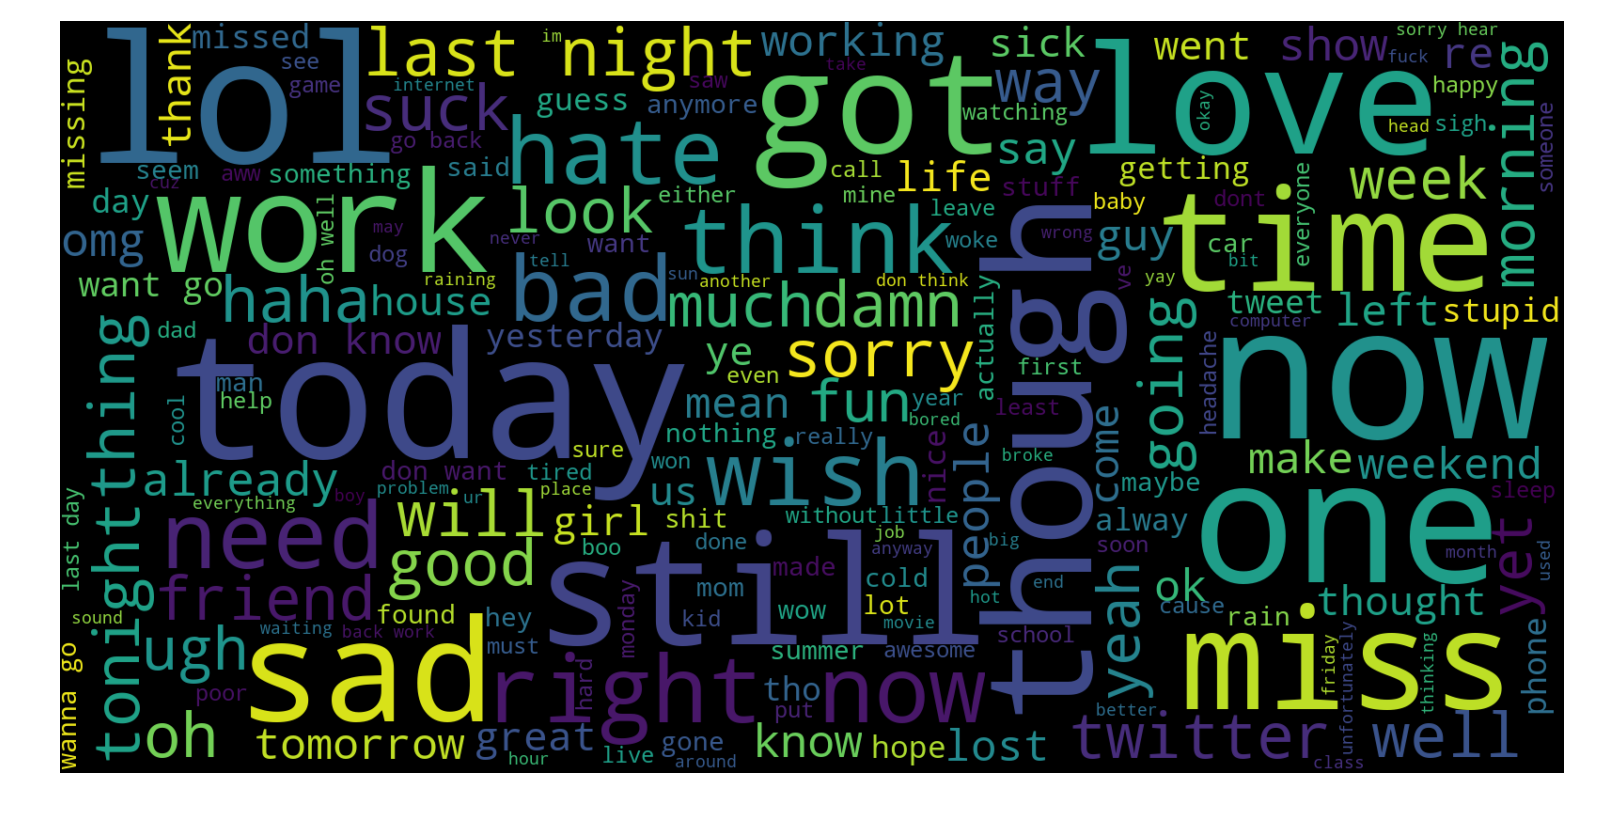

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [12]:
for t in neg_tweets.text[:200]:
    if 'love' in t:
        print(t)

ahh ive always wanted to see rent love the soundtrack
meh almost lover is the exception this track gets me depressed every time
awe i love you too am here i miss you
damn the grind is inspirational and saddening at the same time don t want you to stop cuz i like what u do much love
i m missing you babe but as long as your alive i m happy yawwwnn i m tired my love imma try to sleep hopefully you had a headstart
love the french i tell people here in the south i m qtr french and they snarl at me french are beautiful people


In [13]:
pos_tweets = my_df[my_df.target == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

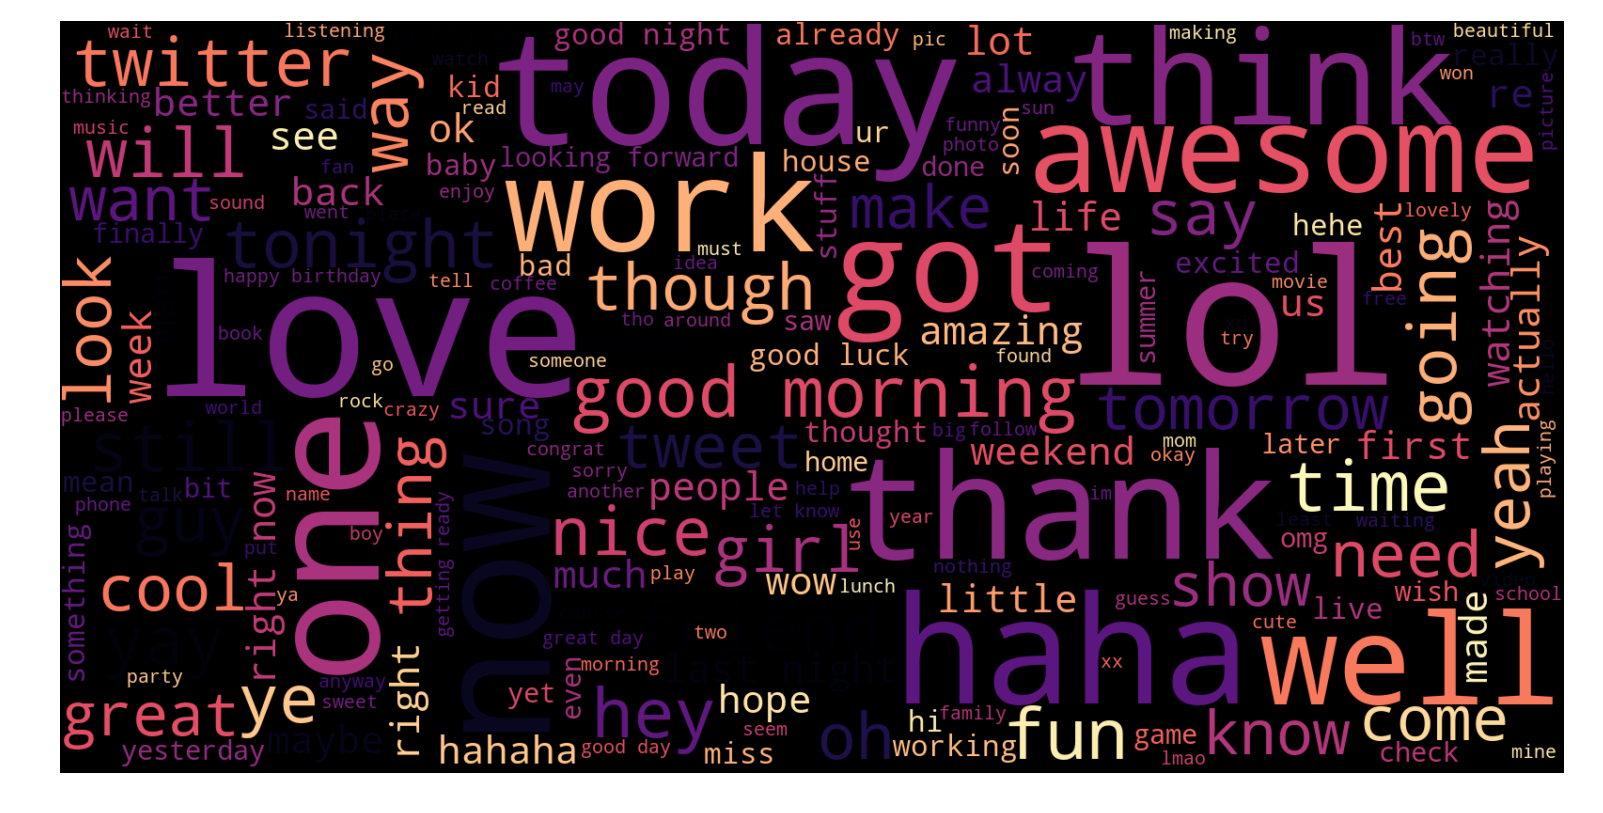

In [14]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [15]:
del pos_tweets, pos_string, neg_tweets, neg_string, wordcloud, df

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(my_df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [17]:
len(cvec.get_feature_names())

273694

In [18]:
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

In [19]:
document_matrix = cvec.transform(my_df.text)

In [20]:
my_df[my_df.target == 0].tail()

,text,target
798498,sick spending my day laying in bed listening to,0
798499,gmail is down,0
798500,rest in peace farrah so sad,0
798501,urbane sounds like a rival is flagging your ad...,0
798502,has to resit exams over summer wishes he worke...,0


In [21]:
%%time
neg_batches = np.linspace(0,798179,100).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(neg_batches)-2):
        print(neg_batches[i+1],"entries' term freuquency calculated")
    i += 1

8062 entries' term freuquency calculated
88686 entries' term freuquency calculated
169310 entries' term freuquency calculated
249934 entries' term freuquency calculated
330558 entries' term freuquency calculated
411183 entries' term freuquency calculated
491807 entries' term freuquency calculated
572431 entries' term freuquency calculated
653055 entries' term freuquency calculated
733679 entries' term freuquency calculated
798179 entries' term freuquency calculated
Wall time: 42min 35s


In [22]:
my_df.tail()

,text,target
1596748,just woke up having no school is the best feel...,1
1596749,thewdb com very cool to hear old walt intervie...,1
1596750,are you ready for your mojo makeover ask me fo...,1
1596751,happy th birthday to my boo of alll time tupac...,1
1596752,happy charitytuesday,1


In [23]:
%%time
pos_batches = np.linspace(798179,1596753,100).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(pos_batches)-2):
        print(pos_batches[i+1],"entries' term freuquency calculated")
    i += 1

806245 entries' term freuquency calculated
886909 entries' term freuquency calculated
967573 entries' term freuquency calculated
1048237 entries' term freuquency calculated
1128901 entries' term freuquency calculated
1209565 entries' term freuquency calculated
1290229 entries' term freuquency calculated
1370893 entries' term freuquency calculated
1451557 entries' term freuquency calculated
1532221 entries' term freuquency calculated
1596753 entries' term freuquency calculated
Wall time: 18min 49s


In [24]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df.head()

,0,1
aa,131,72
aaa,74,36
aaaa,30,20
aaaaa,22,9
aaaaaa,13,9


In [25]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,313081,252707,565788
the,257915,266263,524178
my,190814,126085,316899
it,157489,147907,305396
and,153949,149752,303701
you,103881,198418,302299
is,128094,109106,237200
in,115571,101362,216933
for,99014,117427,216441
of,92800,91256,184056


In [26]:
len(term_freq_df)

273694

In [27]:
term_freq_df.to_csv('term_freq_df.csv',encoding='utf-8')

Text(0.5,1,'Top 500 tokens in tweets')

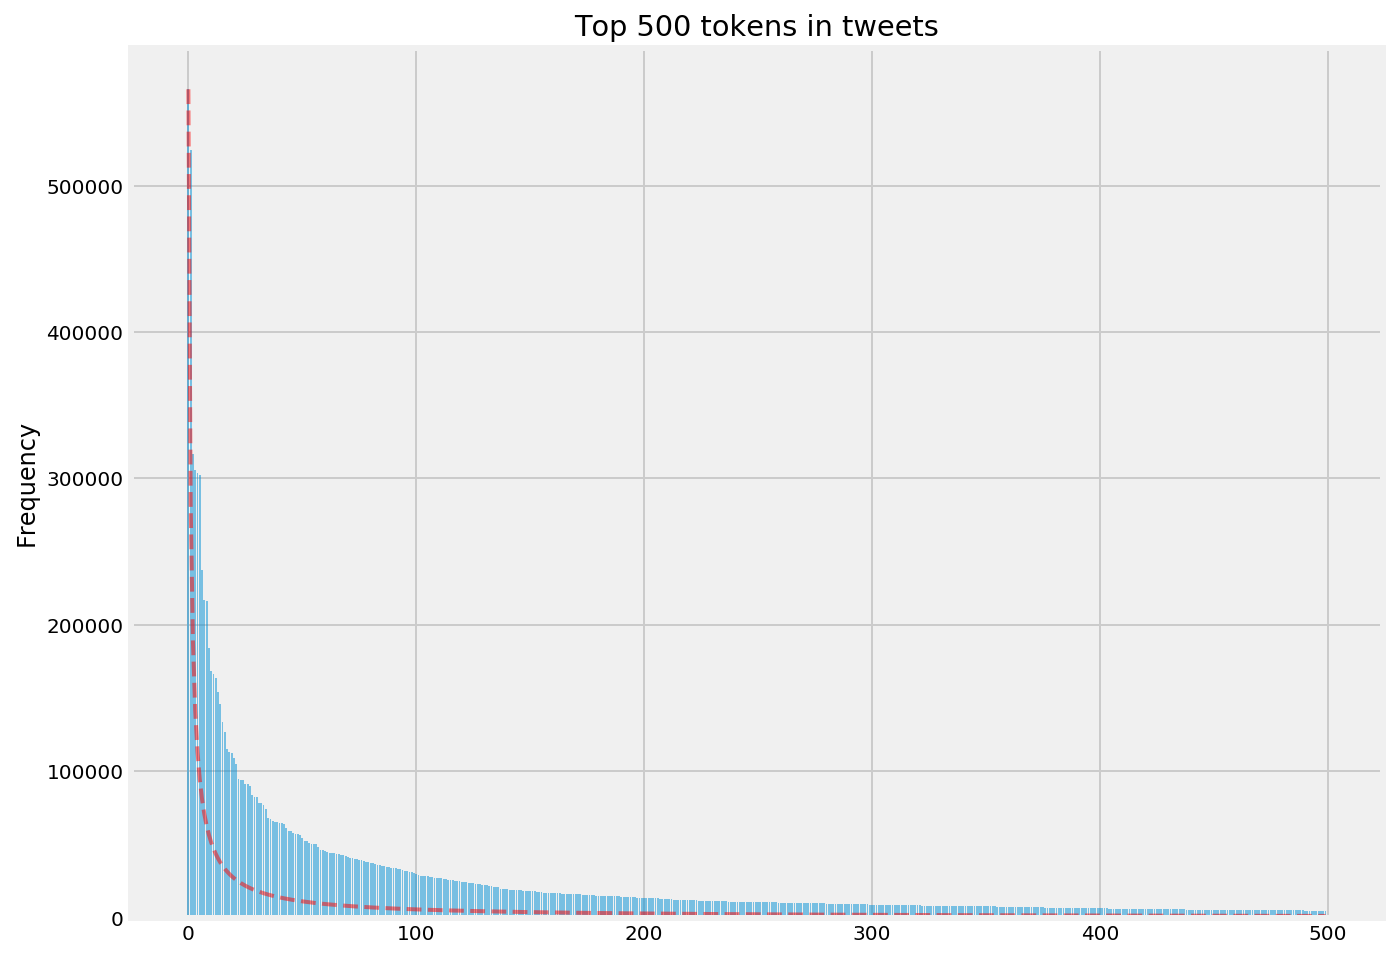

In [28]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

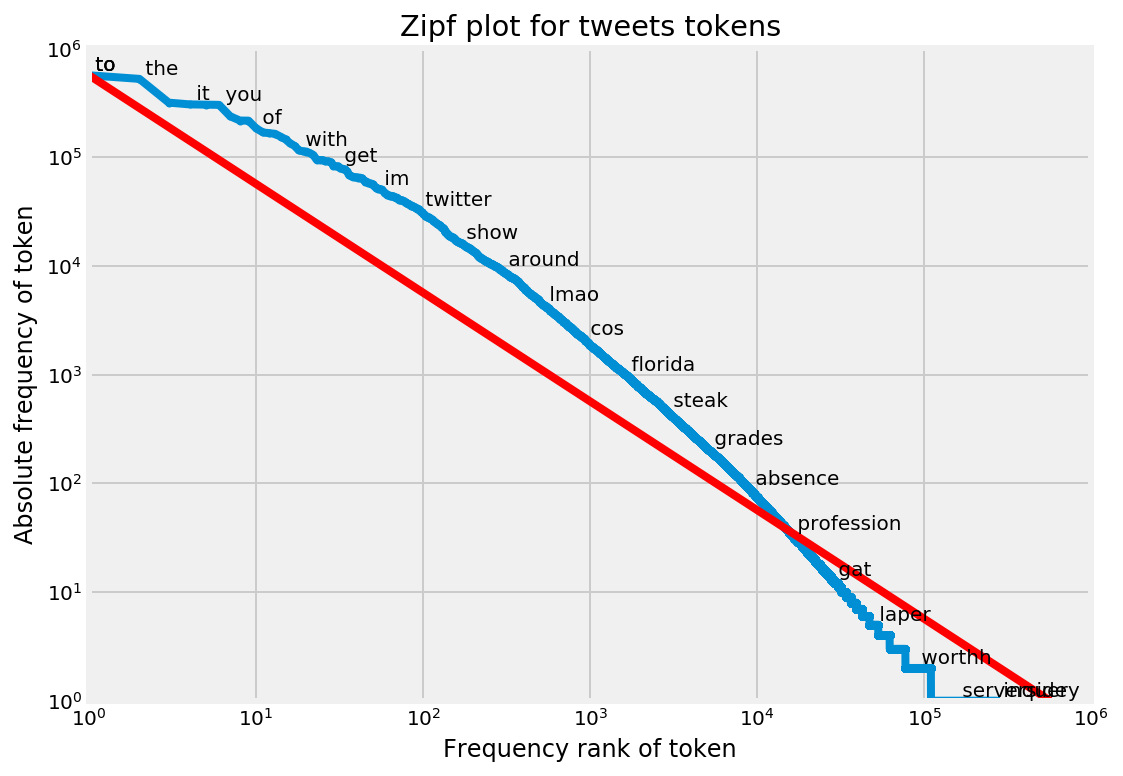

In [29]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

In [30]:
term_freq_df = pd.read_csv('term_freq_df.csv',index_col=0, encoding='utf_8')

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=10000)
cvec.fit(my_df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [32]:
document_matrix = cvec.transform(my_df.text)

In [33]:
%%time
neg_batches = np.linspace(0,798179,10).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    print(neg_batches[i+1],"entries' term freuquency calculated")
    i += 1

88686 entries' term freuquency calculated
177373 entries' term freuquency calculated
266059 entries' term freuquency calculated
354746 entries' term freuquency calculated
443432 entries' term freuquency calculated
532119 entries' term freuquency calculated
620805 entries' term freuquency calculated
709492 entries' term freuquency calculated
798179 entries' term freuquency calculated
Wall time: 27.2 s


In [34]:
%%time
pos_batches = np.linspace(798179,1596019,10).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    print(pos_batches[i+1],"entries' term freuquency calculated")
    i += 1

886827 entries' term freuquency calculated
975476 entries' term freuquency calculated
1064125 entries' term freuquency calculated
1152774 entries' term freuquency calculated
1241423 entries' term freuquency calculated
1330072 entries' term freuquency calculated
1418721 entries' term freuquency calculated
1507370 entries' term freuquency calculated
1596019 entries' term freuquency calculated
Wall time: 27.3 s


In [35]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
just,63981,62938,126919
good,29206,62088,91294
day,41442,48300,89742
like,41049,37503,78552
today,38109,30078,68187
work,45408,19535,64943
love,17061,47747,64808
going,33689,30923,64612
got,33402,28032,61434
lol,23131,36102,59233


Text(0.5,1,'Top 50 tokens in negative tweets')

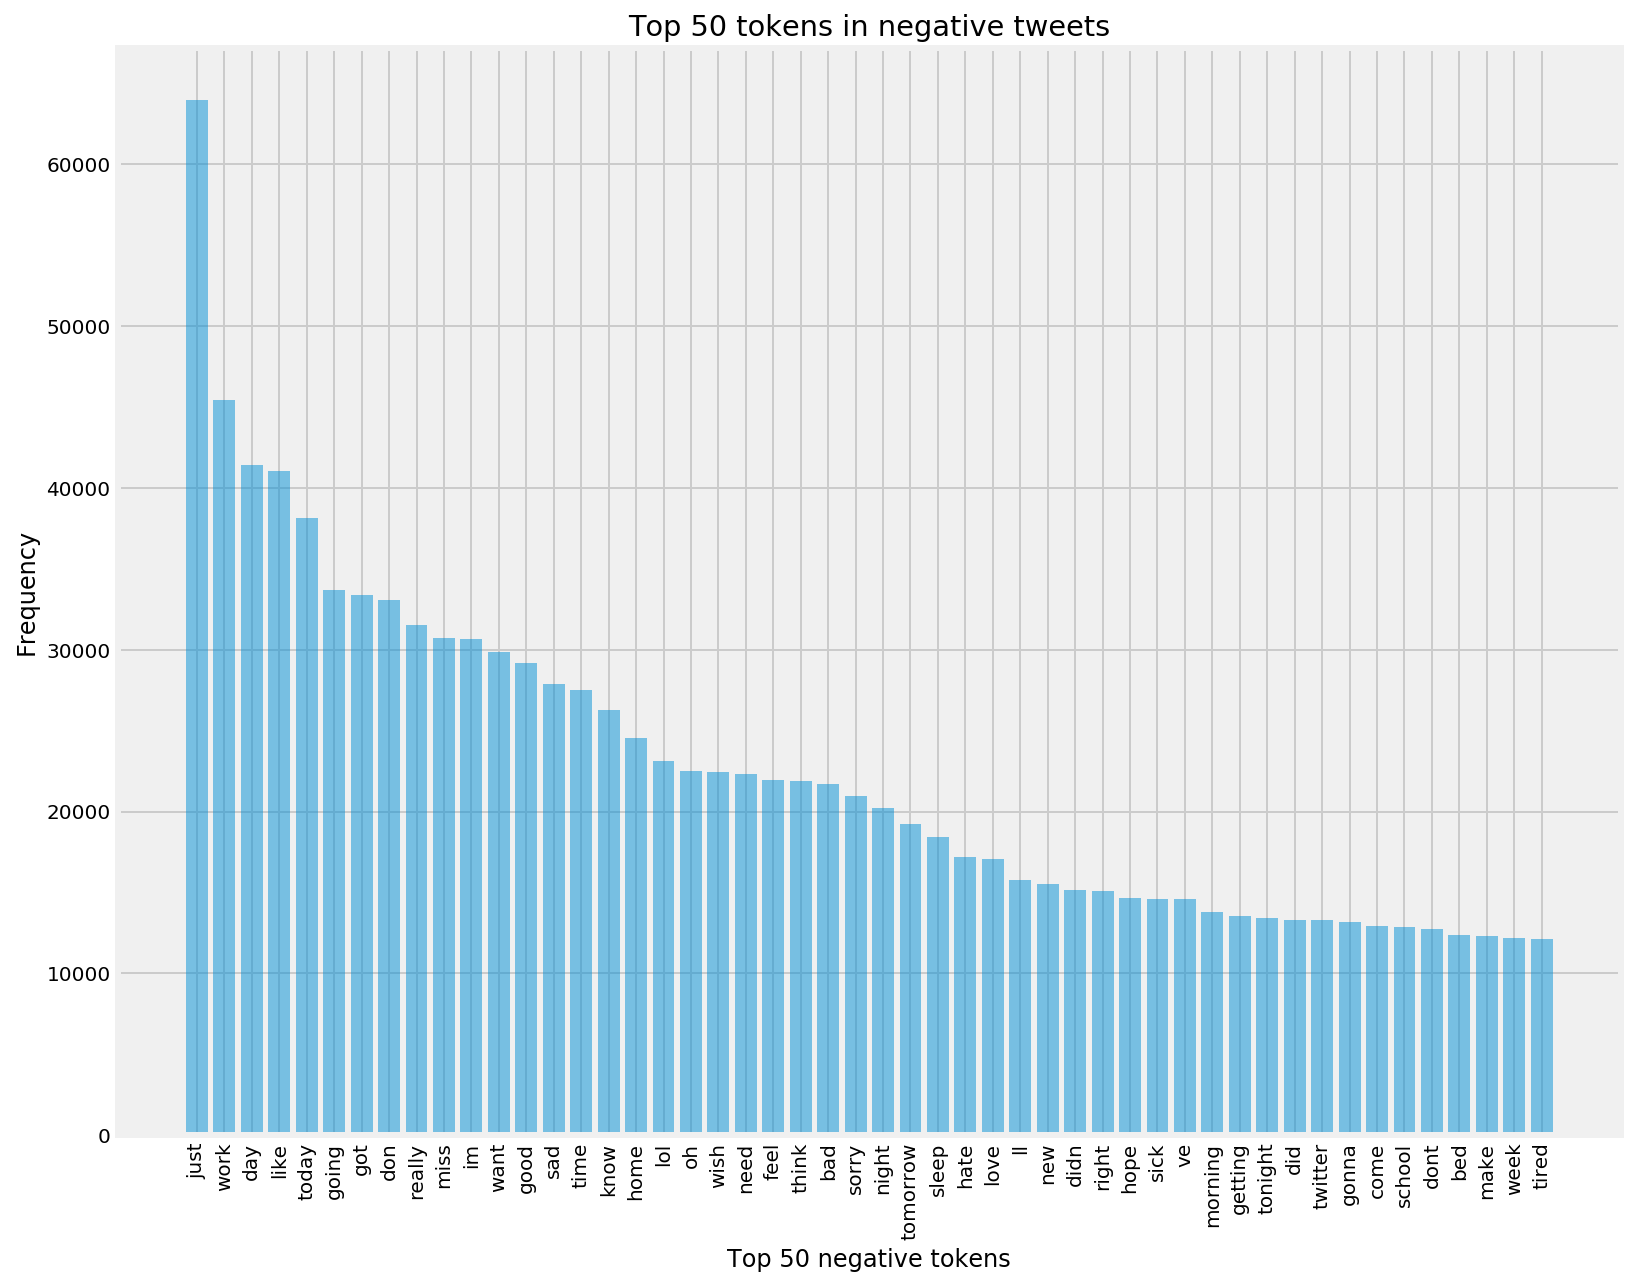

In [36]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

Text(0.5,1,'Top 50 tokens in positive tweets')

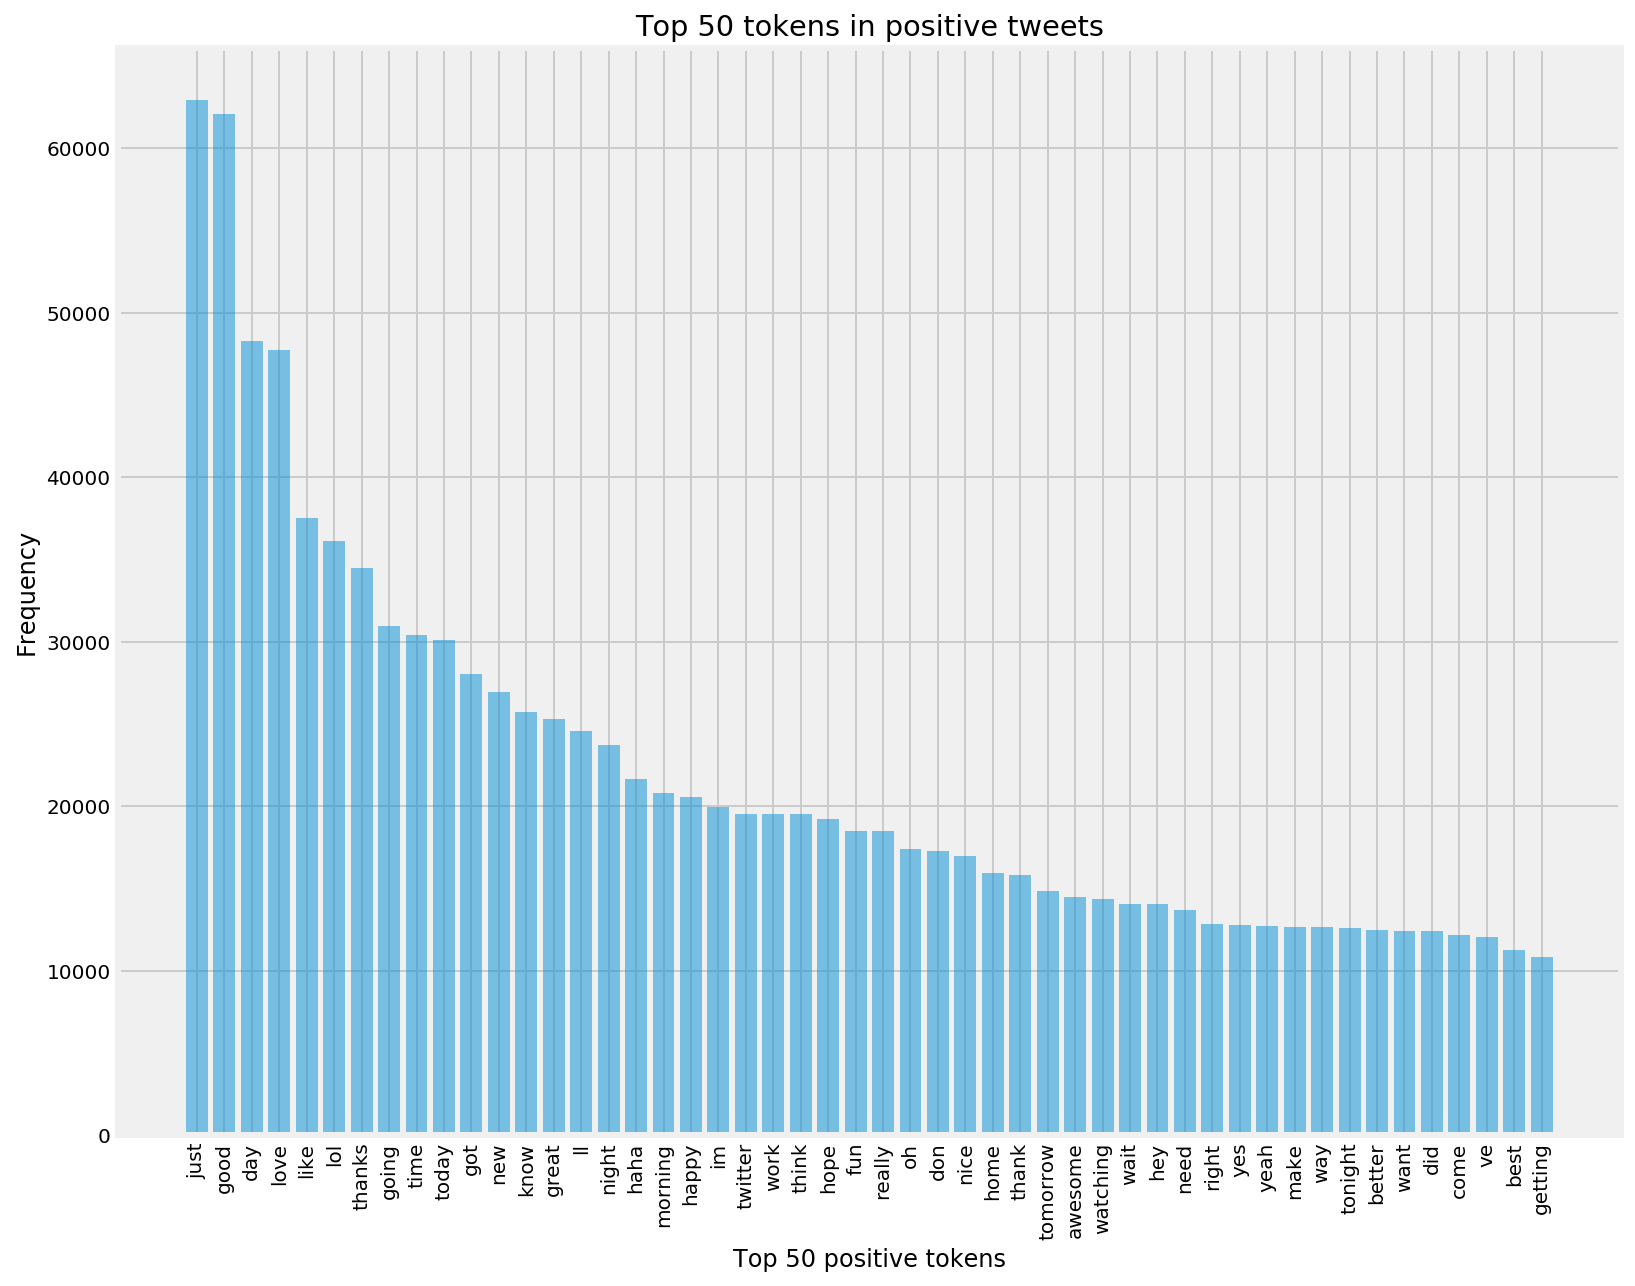

In [37]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Text(0.5,1,'Negative Frequency vs Positive Frequency')

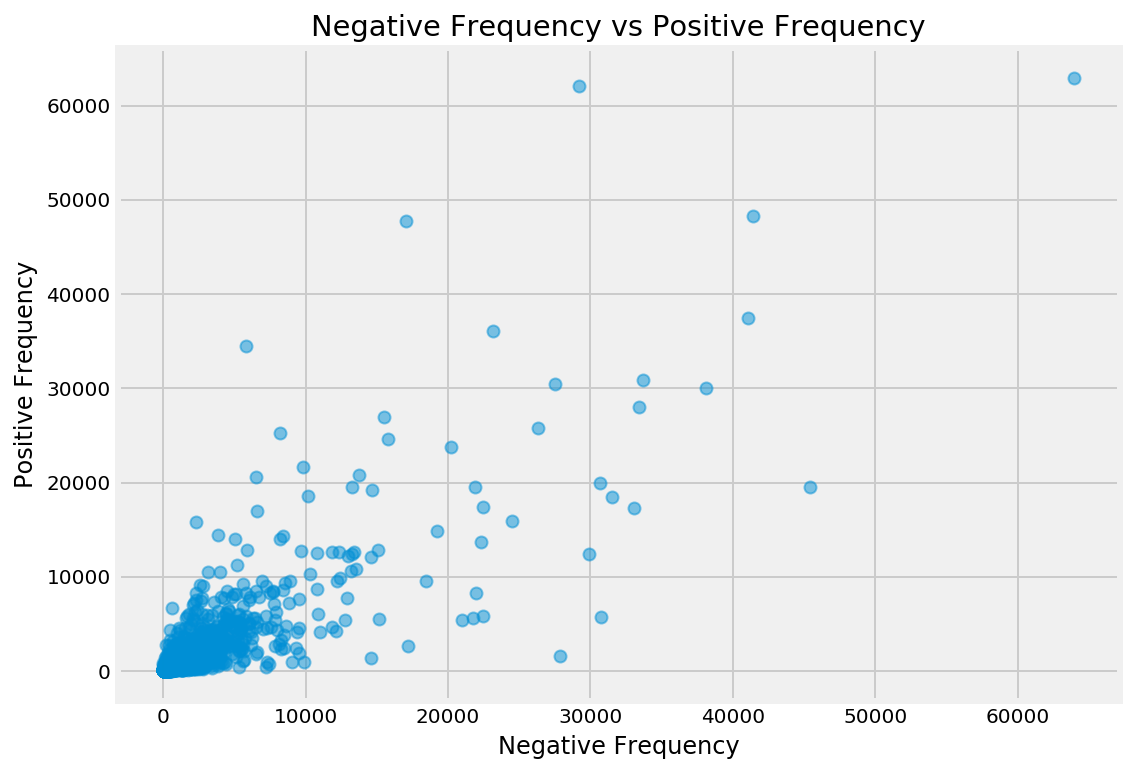

In [38]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [39]:
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
dividends,0,83,83,1.000000
tweeterfollow,0,654,654,1.000000
longestpoemintheworld,0,117,117,1.000000
emailunlimited,0,100,100,1.000000
mileymonday,0,161,161,1.000000
iamsoannoyed,0,246,246,1.000000
tweeteradder,1,830,831,0.998797
shareholder,1,80,81,0.987654
fuzzball,2,98,100,0.980000
recommends,3,109,112,0.973214


In [40]:
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct
just,63981,62938,126919,0.495891,0.014187
good,29206,62088,91294,0.680089,0.013995
day,41442,48300,89742,0.538210,0.010887
love,17061,47747,64808,0.736745,0.010763
like,41049,37503,78552,0.477429,0.008454
lol,23131,36102,59233,0.609491,0.008138
thanks,5800,34488,40288,0.856037,0.007774
going,33689,30923,64612,0.478595,0.006970
time,27525,30424,57949,0.525013,0.006858
today,38109,30078,68187,0.441110,0.006780


In [41]:
from scipy.stats import hmean

term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])
                                                                   if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean
just,63981,62938,126919,0.495891,0.014187,0.027585
good,29206,62088,91294,0.680089,0.013995,0.027426
day,41442,48300,89742,0.538210,0.010887,0.021343
love,17061,47747,64808,0.736745,0.010763,0.021216
like,41049,37503,78552,0.477429,0.008454,0.016613
lol,23131,36102,59233,0.609491,0.008138,0.016061
thanks,5800,34488,40288,0.856037,0.007774,0.015408
going,33689,30923,64612,0.478595,0.006970,0.013741
time,27525,30424,57949,0.525013,0.006858,0.013539
today,38109,30078,68187,0.441110,0.006780,0.013355


In [42]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2.sort_values(by='pos_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
welcome,620,6693,7313,0.915219,0.001509,0.003012,0.995659,0.999329,0.997491
thank,2292,15816,18108,0.873426,0.003565,0.007101,0.990859,1.000000,0.995409
thanks,5800,34488,40288,0.856037,0.007774,0.015408,0.987770,1.000000,0.993847
www,464,4389,4853,0.904389,0.000989,0.001977,0.994703,0.978542,0.986556
awesome,3828,14471,18299,0.790808,0.003262,0.006497,0.966899,1.000000,0.983171
glad,2272,8255,10527,0.784174,0.001861,0.003713,0.963679,0.999969,0.981489
follow,2552,9149,11701,0.781899,0.002062,0.004114,0.962517,0.999996,0.980899
enjoy,1642,5878,7520,0.781649,0.001325,0.002645,0.962388,0.997353,0.979559
sweet,1622,5654,7276,0.777075,0.001274,0.002545,0.959954,0.996248,0.977764
com,2092,6968,9060,0.769095,0.001571,0.003135,0.955402,0.999593,0.976998


In [43]:
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])
                                                                   if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])
term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
sad,27877,1550,29427,0.052673,0.000349,0.000694,0.002299,0.714887,0.004583,0.947327,0.005982,0.011889,0.997701,1.000000,0.998849
hurts,7201,459,7660,0.059922,0.000103,0.000207,0.002651,0.503146,0.005275,0.940078,0.001545,0.003085,0.997349,0.999701,0.998523
sick,14617,1417,16034,0.088375,0.000319,0.000637,0.004554,0.691277,0.009048,0.911625,0.003137,0.006252,0.995446,1.000000,0.997718
sucks,9901,985,10886,0.090483,0.000222,0.000443,0.004734,0.609416,0.009396,0.909517,0.002125,0.004239,0.995266,0.999999,0.997627
poor,7440,742,8182,0.090687,0.000167,0.000334,0.004752,0.560842,0.009425,0.909313,0.001597,0.003187,0.995248,0.999811,0.997524
ugh,9052,1002,10054,0.099662,0.000226,0.000451,0.005597,0.612760,0.011093,0.900338,0.001942,0.003876,0.994403,0.999994,0.997190
missing,7277,992,8269,0.119966,0.000224,0.000446,0.008018,0.610794,0.015829,0.880034,0.001562,0.003118,0.991982,0.999741,0.995846
hate,17203,2623,19826,0.132301,0.000591,0.001177,0.009903,0.868284,0.019582,0.867699,0.003691,0.007352,0.990097,1.000000,0.995024
headache,5317,421,5738,0.073371,0.000095,0.000190,0.003437,0.495367,0.006826,0.926629,0.001141,0.002279,0.996563,0.993289,0.994924
miss,30725,5727,36452,0.157111,0.001291,0.002561,0.014889,0.996647,0.029340,0.842889,0.006593,0.013084,0.985111,1.000000,0.992500


Text(0.5,1,'neg_hmean vs pos_hmean')

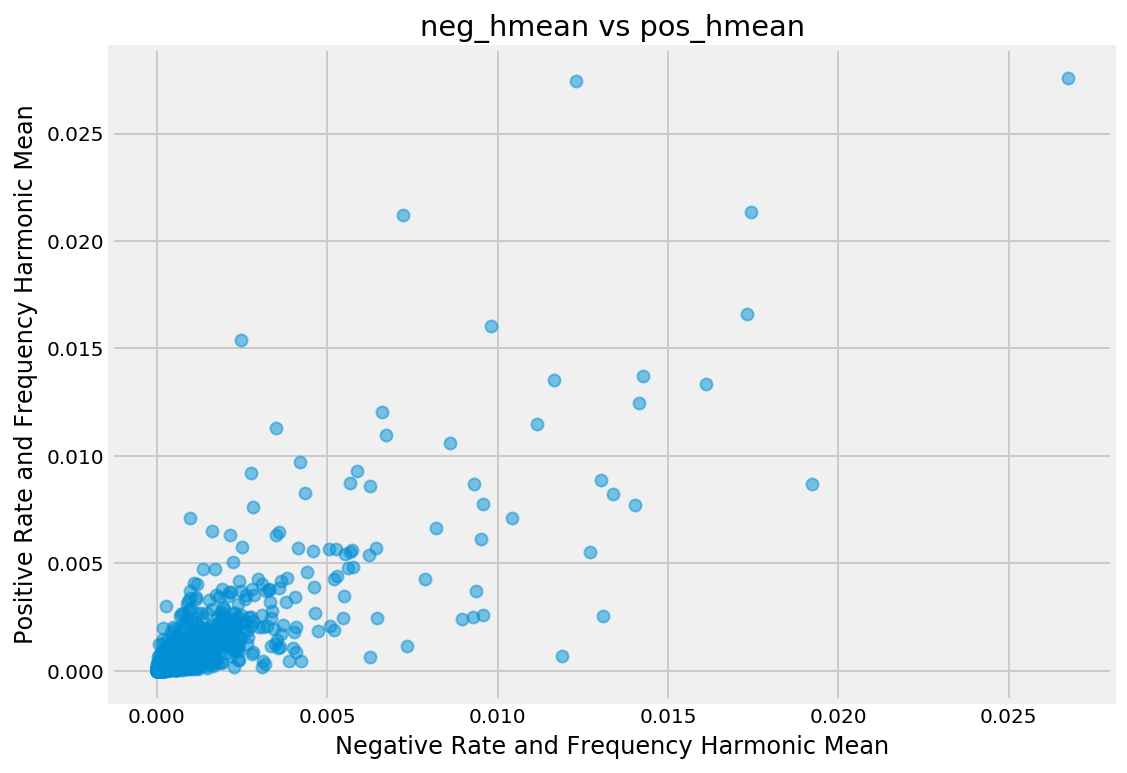

In [44]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Text(0.5,1,'neg_normcdf_hmean vs pos_normcdf_hmean')

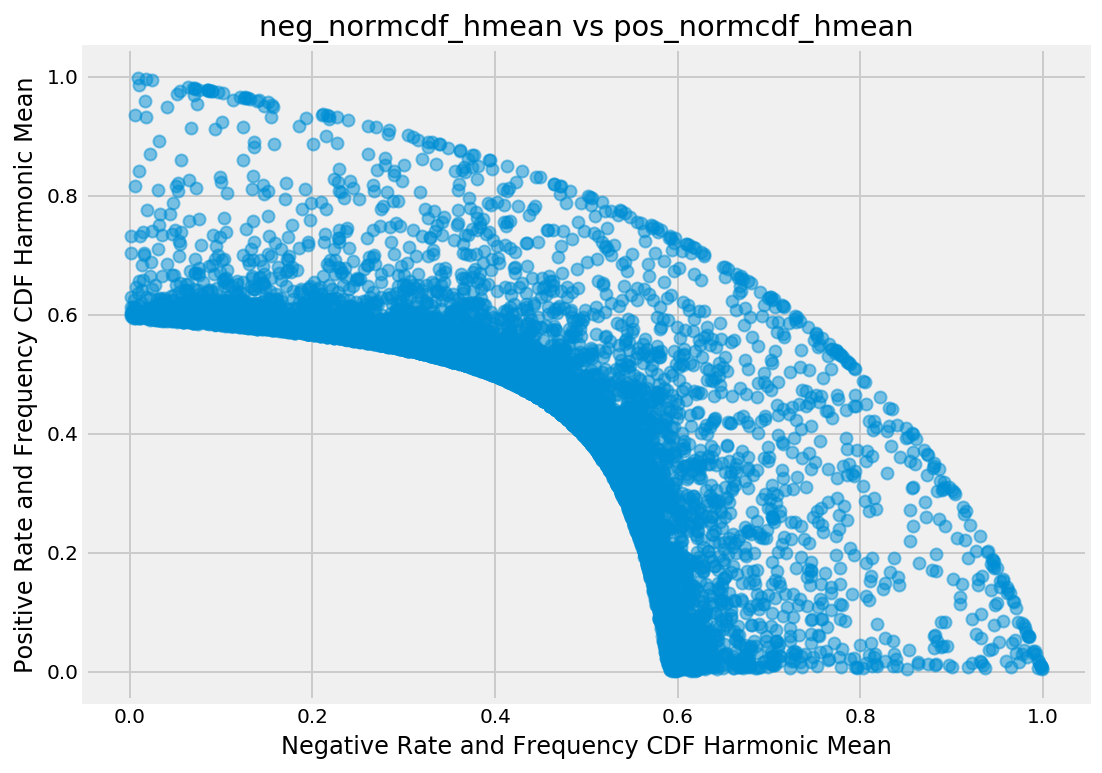

In [45]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [46]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
from bokeh.models import HoverTool
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...